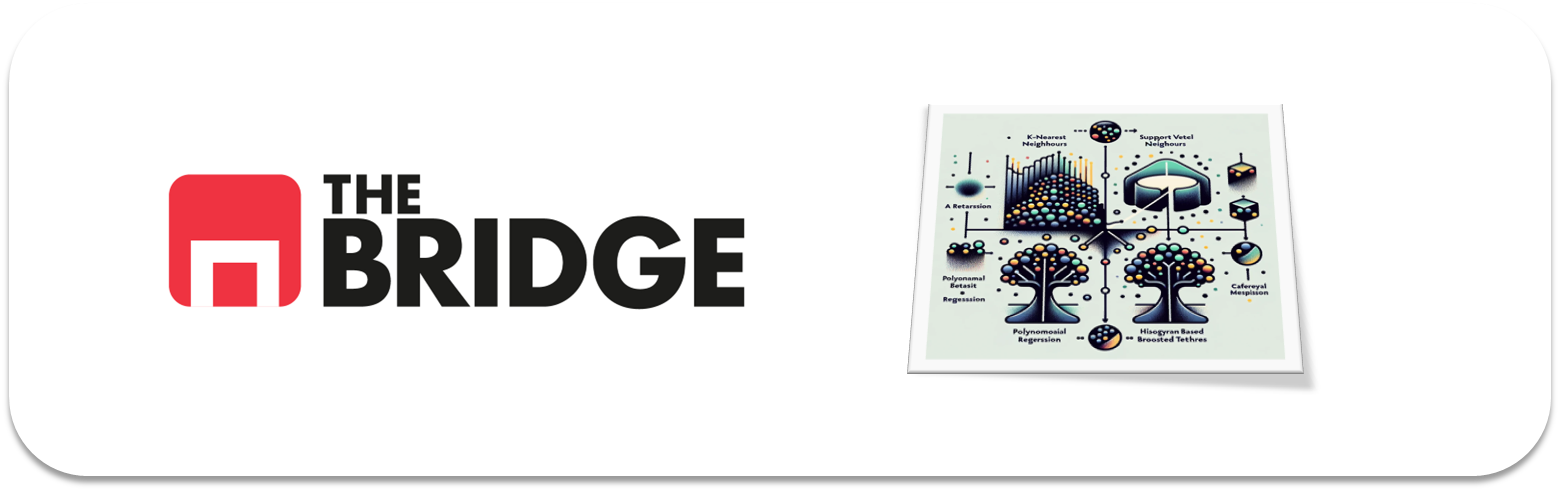

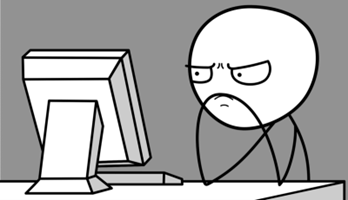

Para ejercitarte y afianzar lo aprendido sobre **Etapas Adicionales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score

from catboost import CatBoostClassifier

## 1. Equilibrado de Datasets

### Ejercicio 1

Carga el dataset de los diamantes (está en el directorio "data") preparado ya para poder entrenar un modelo de clasificación. Muestra las primeras 7 filas y observa el listado de columnas. Muestra la distribución del potencial target ("cut") que ya conoces. ¿Está desbalanceada?

In [2]:
df = pd.read_csv('./data/diamonds_preparado.csv', sep = '|')
df.head(7)

,carat,cut,depth,table,price,x,y,z,color_D,color_E,...,color_I,color_J,clarity_IF,clarity_VVS1,clarity_VVS2,clarity_VS1,clarity_VS2,clarity_SI1,clarity_SI2,clarity_I1
0,0.23,Ideal,61.5,55.0,326,3.95,3.98,2.43,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0.21,Premium,59.8,61.0,326,3.89,3.84,2.31,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0.23,Good,56.9,65.0,327,4.05,4.07,2.31,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0.29,Premium,62.4,58.0,334,4.20,4.23,2.63,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0.31,Good,63.3,58.0,335,4.34,4.35,2.75,0,0,...,0,1,0,0,0,0,0,0,1,0
5,0.24,Very Good,62.8,57.0,336,3.94,3.96,2.48,0,0,...,0,1,0,0,1,0,0,0,0,0
6,0.24,Very Good,62.3,57.0,336,3.95,3.98,2.47,0,0,...,1,0,0,1,0,0,0,0,0,0


In [3]:
df.columns

Index(['carat', 'cut', 'depth', 'table', 'price', 'x', 'y', 'z', 'color_D',
       'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J',
       'clarity_IF', 'clarity_VVS1', 'clarity_VVS2', 'clarity_VS1',
       'clarity_VS2', 'clarity_SI1', 'clarity_SI2', 'clarity_I1'],
      dtype='object')

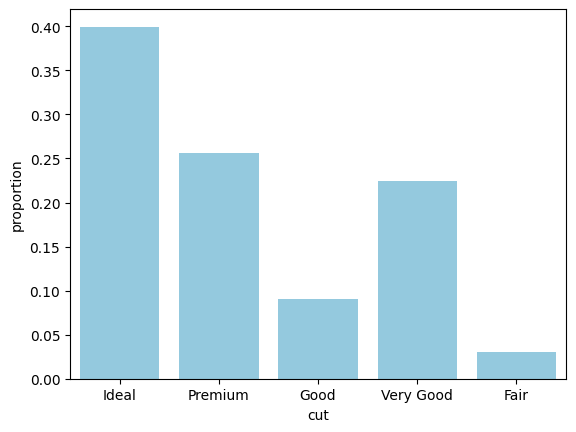

In [4]:
target = 'cut'
sns.countplot(df, x = 'cut', stat = 'proportion', color = 'skyblue');

Sí, target está desbalanceado porque tiene 5 categorías con distribuciones de valores muy diferentes.  

*Nota: 'cut' (target) es la única variable donde se ha mantenido su tipo original (object), ya que el resto de variables categóricas (color y clarity) ya han sido tratadas con un OneHotEncoder.*

 ### Ejercicio 2

 Crea un train_set y un test_set al 20%, crea los pares X,y de train y test con el target en la variable "cut", considera el resto como features.

In [5]:
y = df[target]
X = df.drop(target, axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Ejercicio 3

Instancia un modelo RandomForest con max_depth a 5 y sin tocar otro hiperparámetro, entrénalo con el X_train y el y_train. Y muestra el classification_report para el X_train.

In [6]:
rfc = RandomForestClassifier(max_depth = 5, random_state = 42)
rfc.fit(X_train, y_train)

print(classification_report(y_train, rfc.predict(X_train)))

              precision    recall  f1-score   support

        Fair       0.89      0.66      0.76      1275
        Good       0.81      0.35      0.49      3902
       Ideal       0.78      0.94      0.85     17259
     Premium       0.59      0.87      0.70     11016
   Very Good       0.63      0.22      0.33      9700

    accuracy                           0.70     43152
   macro avg       0.74      0.61      0.63     43152
weighted avg       0.70      0.70      0.66     43152



### Ejercicio 4

Dado el desbalanceo, nos queremos fijar en el recall medio (la media del recall considerando cada clase). Usando "cross_val_score", hagamos una estimación un poco más precisa (y en general pesimista) de cual sería ese recall medio del modelo en general. Asigna para ello a `scoring` el valor `balanced_accuracy`

In [7]:
mean_recall = cross_val_score(rfc, X_train, y_train, cv = 5, scoring = 'balanced_accuracy', n_jobs = -1)
print('Recall medio:', np.mean(mean_recall))

Recall medio: 0.6024255909998344


### Ejercicio 5

El resultado obtenido en el ejercicio 4 es bueno o malo dependiendo de lo que "Negocio" nos diga. Supón que negocio nos dice que quiere como mínimo que cada clase tenga un 50% de recall (que al menos un 50% de cada clase de diamente se etiquete bien por el modelo). Viendo el report anterior seguro que ves que así no llegamos. Tenemos que hacer algo, ayudar al modelo a conseguir ese objetivo. ¿Cómo? Con las téncias de equilibrado. Empecemos por aumentar las clases minoritarias con SMOTE. 

Crea un X_train y un y_train balanceados aplicando SMOTE; muestra el reparto del y_train para ver que se ha balanceado en todas las clases

In [8]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [9]:
smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [10]:
print('Original:', y_train.value_counts(), sep = '\n', end = '\n\n')
print('SMOTE:', y_train_smote.value_counts(), sep = '\n', end = '\n\n')
print('X_train', X_train.shape)
print('X_train_smote', X_train_smote.shape)

Original:
cut
Ideal        17259
Premium      11016
Very Good     9700
Good          3902
Fair          1275
Name: count, dtype: int64

SMOTE:
cut
Good         17259
Very Good    17259
Premium      17259
Ideal        17259
Fair         17259
Name: count, dtype: int64

X_train (43152, 22)
X_train_smote (86295, 22)


### Ejercicio 6

Entrena con el nuevo X,y y muestra los resultados del modelo así entrenado pero prediciendo contra el X_test creado en el ejercicio 2. Comenta el resultado. NOTA: En el caso de querer balancear con tecnicas de Oversampling y Undersampling, es interesante crear un set de validación adicional al de test y train, para no tener que usar el test como validación de los modelos.

In [11]:
rfc_smote = RandomForestClassifier(max_depth = 5, random_state = 42)
rfc_smote.fit(X_train_smote, y_train_smote)

print(classification_report(y_train_smote, rfc_smote.predict(X_train_smote)))

              precision    recall  f1-score   support

        Fair       0.96      0.74      0.84     17259
        Good       0.60      0.70      0.65     17259
       Ideal       0.68      0.94      0.79     17259
     Premium       0.50      0.81      0.62     17259
   Very Good       0.65      0.06      0.11     17259

    accuracy                           0.65     86295
   macro avg       0.68      0.65      0.60     86295
weighted avg       0.68      0.65      0.60     86295



El recall ha mejorado en general salvo para 'Very Good', que es muy bajo y habría que corregirlo.

### Ejercicio 7

Prueba ahora a mejorar el modelo empleando el hiperparámetro class_weight. Reinstancia el modelo, entrenalo contra el X_train inicial y luego muestra el report contra el test. Comenta brevemente el resultado.

In [12]:
rfc_op = RandomForestClassifier(max_depth = 5, class_weight = 'balanced', random_state = 42)
rfc_op.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [13]:
print(classification_report(y_test, rfc_op.predict(X_test)))

              precision    recall  f1-score   support

        Fair       0.88      0.84      0.86       335
        Good       0.49      0.71      0.58      1004
       Ideal       0.79      0.93      0.85      4292
     Premium       0.62      0.82      0.70      2775
   Very Good       0.62      0.06      0.11      2382

    accuracy                           0.69     10788
   macro avg       0.68      0.67      0.62     10788
weighted avg       0.68      0.69      0.63     10788



Han salido casi los mismos recall que en el caso de SMOTE, incluso ligeramente mejores. Sigue estando el problema de la clase 'Very Good', pero el accuracy también es ligeramente mejor.

### Ejercicio 8

Para terminar con nuestros intentos de mejorar la clasificación "global", vamos a aplicar el bajomuestreo de las clases mayoritarias, aunque no tengamos muchas esperanzas puestas en ello. Para poder hacerlo vamos a usar la clase `RandomUnderSampler` de la biblioteca imblearn. Investiga un poco sobre su funcionamiento (pista es equivalente en su uso a la clase Smote) y crea un dataset con undersampling de forma que las clases estén equilibradas. Muestra las frecuencias del target. ¿Por qué no tenemos muchas expectativas, en este caso, sobre esta técnica? 

In [14]:
rus = RandomUnderSampler(random_state = 42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [15]:
print('Original:', y_train.value_counts(), sep = '\n', end = '\n\n')
print('RUS:', y_train_rus.value_counts(), sep = '\n', end = '\n\n')
print('X_train', X_train.shape)
print('X_train_rus', X_train_rus.shape)

Original:
cut
Ideal        17259
Premium      11016
Very Good     9700
Good          3902
Fair          1275
Name: count, dtype: int64

RUS:
cut
Fair         1275
Good         1275
Ideal        1275
Premium      1275
Very Good    1275
Name: count, dtype: int64

X_train (43152, 22)
X_train_rus (6375, 22)


In [18]:
print('Entradas y_train:', len(y_train))
print('Entradas y_train_rus:', len(y_train_rus))

Entradas y_train: 43152
Entradas y_train_rus: 6375


No tenemos muchas espectativas porque ha habido una reducción muy importante del dataset (de 43152 entradas a 6375).

### Ejercicio 9

Entrena, ahora con class_weight a None, un RandomForest como el inicial pero contra el train creado en el ejercicio 8, muestra su informe de clasificación sobre la predicción contra test y comenta el resultado.

In [19]:
rfc_rus = RandomForestClassifier(max_depth = 5, class_weight = None, random_state = 42)
rfc_rus.fit(X_train_rus, y_train_rus)

print(classification_report(y_train_rus, rfc_rus.predict(X_train_rus)))

              precision    recall  f1-score   support

        Fair       0.95      0.83      0.88      1275
        Good       0.72      0.66      0.69      1275
       Ideal       0.67      0.93      0.78      1275
     Premium       0.50      0.86      0.63      1275
   Very Good       0.65      0.07      0.12      1275

    accuracy                           0.67      6375
   macro avg       0.70      0.67      0.62      6375
weighted avg       0.70      0.67      0.62      6375



Más o menos los resultados son iguales que en los otros casos, seguimos teniendo el problema del recall en 'Very Good'.

## 2. Análisis de Errores

### Ejercicio 10

Muestra la matriz de confusión con "ConfusionMatrixDisplay.from_predictions" para el clasificador entrenado con el hiperparámetro class_weight con el valor "balanced" (el del ejercicio 7). Asigna el valor "true" (ojo es un string, no el booleano True) al argumento normalize. Comenta que estamos viendo y hacia donde se dirigen los errores de clasificación de "Very Good"

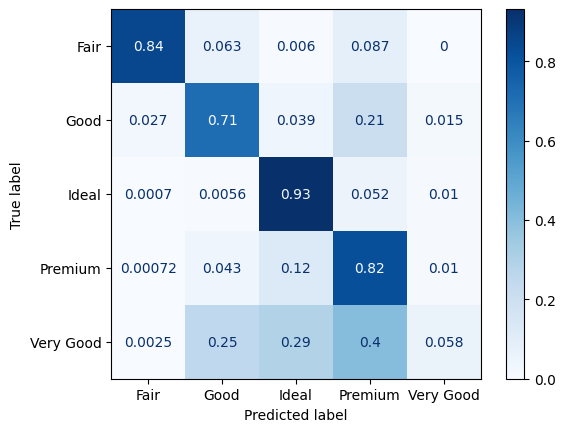

In [29]:
ConfusionMatrixDisplay.from_predictions(y_test, rfc_op.predict(X_test), normalize = 'true', cmap = 'Blues');

Con *normalize = 'true'* estamos viendo el recall de cada clase: cada fila muestra la proporción de valores que se han clasificado en cada clase siendo el label de la clase el valor real. El orden de las clases en base a la cantidad de entradas que tienen es: **Ideal > Premium > Very Good > Good > Fair**
   
'Very Good' es la clase de en medio y vemos que el reparto de las entradas que realmente tienen esa clase es:
* **29%** de 'Very Good' clasificado como 'Ideal'
* **40%** de 'Very Good' clasificado como 'Premium'
* **5.8%** de 'Very Good' clasificado como 'Very Good' (correcto)
* **25%** de 'Very Good' clasificado como 'Good'
* **0.25%** de 'Very Good' clasificado como 'Fair'

Observamos que mayoritariamente hace una clasificación hacia arriba, es decir, asigna una clase de mayor calidad de la que tiene. Concretamente hacia 'Premium' por lo que el primer paso sería ver cómo hacer que el modelo diferencie bien entre 'Very Good' y 'Premium'.  

Sin embargo, el caso contrario no ocurre: solo el 1% de los etiquetados como 'Very Good' era 'Premium'.

### Ejercicio 11

Muestra ahora la matriz de confusión, empleando la misma función, pero esta vez enseñando los porcentajes de distribució de los errores en la predicción, para eso emplea normalize = "pred" como argumeto y date cuenta de que las columnas son las que ahora suman el 100%. Comenta el resultado respecto a "Premium" como predicción y a lo que se equivoca respecto a "Very Good". 

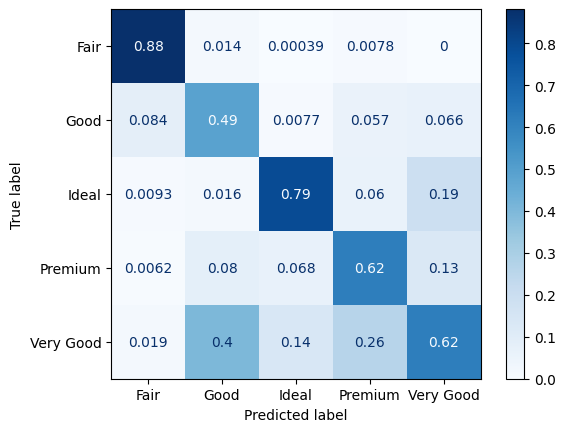

In [30]:
ConfusionMatrixDisplay.from_predictions(y_test, rfc_op.predict(X_test), normalize = 'pred', cmap = 'Blues');

Con *normalize = 'pred'* estamos viendo el precision de cada clase: la proporción de cada true label que se ha clasificado como clase 'x'. Con respecto a 'Very Good' observamos que:

* **19%** de lo que se ha clasificado como 'Very Good' era 'Ideal'
* **13%** de lo que se ha clasificado como 'Very Good' era 'Premium'
* **62%** de lo que se ha clasificado como 'Very Good' era 'Very Good' (correcto)
* **6.6%** de lo que se ha clasificado como 'Very Good' era 'Good'
* **0%** de lo que se ha clasificado como 'Very Good' era 'Fair'

Observamos que cuando predice 'Very Good', solo el 13% de las veces era 'Premium' pero cuando predice 'Premium' el 26% de las veces realmente era 'Very Good'. Ahora se equivoca más con 'Good', ya que el 40% de las veces que predice 'Good' realmente era 'Very Good'. Estas dos clases son adyacentes a 'Very Good', por lo que podría ser beneficioso que detrás de este modelo hubiera otro modelo que corrigiese el error de clasificación, sobre todo para estas dos clases.

### Ejercicio 12

Dada la relación entre los errores de "Very Good" y "Prediction" que puedes haber observado en los ejercicios anteriores, una posible mejora es introducir un modelo que corrija esos errores, pero esa es la filosofía de los Gradient Boosted Trees. Provemos esa línea: Entrena un CatBoost con los hiperparámetros ajustados para que no emplee más de 5 niveles en sus árboles intermedios y para que balanceé las clases.

1. Obtener el "balanced_accuracy" primero con una validación cruzada.
2. Evaluálo después de contra el test.

In [39]:
catb_clf = CatBoostClassifier(depth = 5, auto_class_weights = 'Balanced', verbose = False)

cross_val = cross_val_score(catb_clf, X_train, y_train, cv = 5, scoring = 'balanced_accuracy', n_jobs = -1)
print(np.mean(cross_val))

0.7864038362819652


In [40]:
cross_val

array([0.79242887, 0.78592613, 0.78743412, 0.78258103, 0.78364903])

In [41]:
catb_clf.fit(X_train, y_train)
print(classification_report(y_test, catb_clf.predict(X_test)))

              precision    recall  f1-score   support

        Fair       0.87      0.93      0.90       335
        Good       0.70      0.80      0.74      1004
       Ideal       0.84      0.89      0.87      4292
     Premium       0.79      0.83      0.81      2775
   Very Good       0.69      0.53      0.60      2382

    accuracy                           0.79     10788
   macro avg       0.78      0.79      0.78     10788
weighted avg       0.78      0.79      0.78     10788



Ahora 'Very Good' tiene un recall mucho mejor del que tenía originalmente, por lo que el problema realmente era el tipo de algoritmo que se estaba usando para hacer el modelo.